In [27]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
adata = sc.read("/mnt/c/Users/sneha/BrainCellAtlas/data/human_mtg_brain_atlas_final.h5ad")
sc.settings.figdir = '../results/figures/'

In [25]:

x = adata.obsm["X_pca"][:,:50]  # Use first 50 PCAs
y = adata.obs["cell_type"]
# removal of entries with NaN in y
mask = ~y.isna()
x_clean = x[mask]
y_clean = y[mask]

x_train, x_test, y_train, y_test = train_test_split(
    x_clean, y_clean, 
    test_size=0.2, 
    stratify=y_clean, 
    random_state=42
)

In [14]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))


                         precision    recall  f1-score   support

             Astrocytes       0.99      0.99      0.99       183
      Endothelial cells       0.99      0.87      0.93       111
Excitatory Neurons L2/3       0.98      0.99      0.99       299
Excitatory Neurons L5/6       0.97      1.00      0.98       273
     Inhibitory Neurons       0.98      0.99      0.98       203
           Microganglia       1.00      1.00      1.00       117
                   OPCs       0.99      0.99      0.99       140
       Oligodendrocytes       0.99      1.00      1.00       172

               accuracy                           0.99      1498
              macro avg       0.99      0.98      0.98      1498
           weighted avg       0.99      0.99      0.99      1498



Confusion Matrix:
 [[181   0   1   0   0   0   1   0]
 [  0  97   3   7   3   0   0   1]
 [  0   0 297   0   2   0   0   0]
 [  0   0   1 272   0   0   0   0]
 [  0   1   0   1 201   0   0   0]
 [  0   0   0   0   0 117   0   0]
 [  1   0   0   0   0   0 139   0]
 [  0   0   0   0   0   0   0 172]]


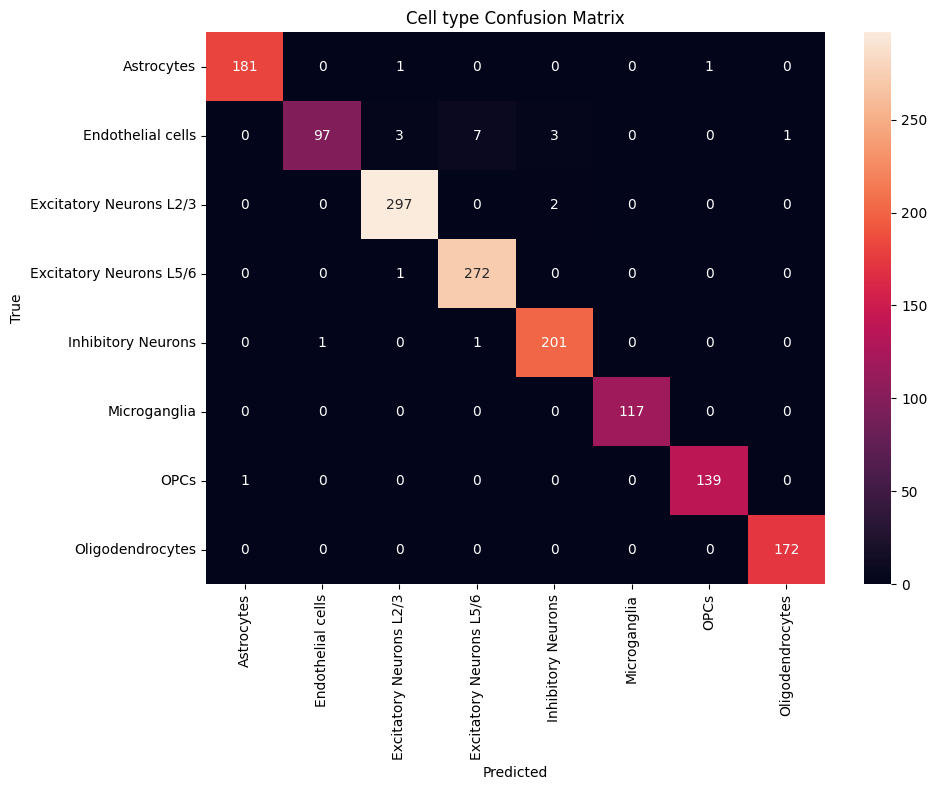

In [10]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=clf.classes_, yticklabels=clf.classes_)

plt.title('Cell type Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('../results/figures/cell_type_confusion_matrix.pdf')

['/mnt/c/Users/sneha/BrainCellAtlas/results/models/cell_type_classifier.pkl']

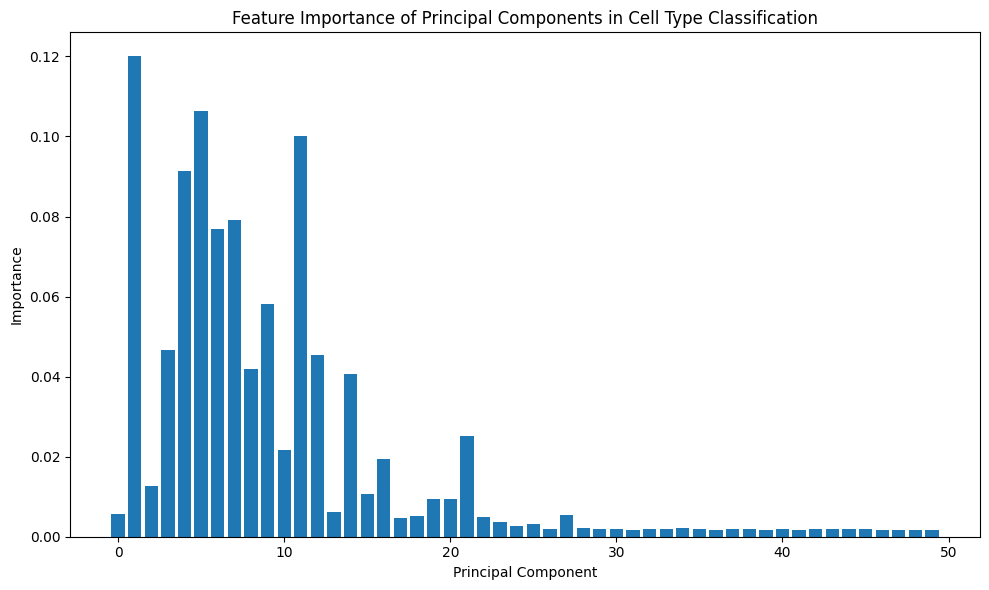

In [22]:
#importance of the features and which principal components related to which genes are more important'
importances = clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Principal Component')
plt.ylabel('Importance')
plt.title('Feature Importance of Principal Components in Cell Type Classification')
plt.tight_layout()
plt.savefig('../results/figures/pc_feature_importance.pdf')
import os
os.makedirs('/mnt/c/Users/sneha/BrainCellAtlas/results/models', exist_ok=True)
joblib.dump(clf, '/mnt/c/Users/sneha/BrainCellAtlas/results/models/cell_type_classifier.pkl')

In [ ]:
gene_list = pd.read_csv('/mnt/c/Users/sneha/OneDrive/Desktop/gene expression matrices human/genes-rows.csv')
target_genes = gene_list['gene'].tolist()
gene_present = [g 
                for g in target_genes if g in adata.raw.var_names]
language_keywords = ['FOXP2', 'CNTNAP2', 'ROBO', 'DYX', 'KIAA', 'DCDC2']
language_genes = [g for g in gene_present if any(keyword in g.upper() for keyword in language_keywords)]
X_genes = adata.raw[:, language_genes].X.toarray()
X_genes_clean = X_genes[mask]  

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_genes_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
)

clf_genes = RandomForestClassifier(n_estimators=200, random_state=42)
clf_genes.fit(X_train_g, y_train_g)

print(f"\nClassifier Performance:")
print(f"Accuracy with PCA (all genes): {clf.score(x_test, y_test):.3f}")
print(f"Accuracy with language genes only: {clf_genes.score(X_test_g, y_test_g):.3f}")
print(f"Number of features - PCA: 50, Language genes: {len(language_genes)}")


Classifier Performance:
Accuracy with PCA (all genes): 0.985
Accuracy with language genes only: 0.347
Number of features - PCA: 50, Language genes: 8
